## Task:
 To build an algorithm to reproduce activities from the sensor data provided.

Data Science Case Study
A roofbolter is an underground mining machine that reinforces roofs of mine haulageways. It essentially drills holes in the roof and secures a bolt in each hole. The machine has two engines, a Diesel engine for traveling and a hydraulic engine for the drilling/anchoring.
In data_case_study.csv you have about a week’s worth of second-based sensor data from an operating roofbolter. For this week we have labeled the data with the activity that the roofbolter is performing:
- Machine off, i.e. all engines are turned off
- Idle: Machine is on but not working
- Traveling: Machine is moving in the mine
- Hole Setup: Preparation for drilling/anchoring
- Drilling
- Anchoring: Putting a bolt in a drilled hole
- Transitional Delay: Other hydraulic activities
Your task is to build an algorithm to reproduce these activities from the sensor data provided.
We are not only interested in how you approach this task from a modeling point of view but are also keen to see how you write (production) code. We also hope that this task can give you some insight into the kind of problems we face and figuring out if you enjoy this problem space.

# Data preparation part

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split

In [2]:
# change to directory containing data files
os.getcwd()


'/home/nath/tasks/talpa-datascience-task/notebooks'

In [3]:
# Import the data file for analysis
os.getcwd()

'/home/nath/tasks/talpa-datascience-task/notebooks'

In [4]:
# Print first 5 columns
os. chdir("~/tasks/talpa-datascience-task/")
ds_case_file = 'data/raw/data_case_study.csv'
ds_case_data = pd.read_csv(ds_case_file, sep=',')

In [5]:
ds_case_data.head()
# print rows and column sizes for the data set

,Unnamed: 0,timestamp,engine_speed,hydraulic_drive_off,drill_boom_in_anchor_position,pvalve_drill_forward,hydraulic_pump,bolt,boom_lift,boom_lower,boom_forward,boom_backward,drill_boom_turn_left,drill_boom_turn_right,drill_boom_turn_forward,drill_boom_turn_backward,beam_right,beam_left,anchor,activity
0,0,1534192356,74.898806,0.0,0.479059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Idle
1,1,1534192357,75.139756,0.0,0.479059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Idle
2,2,1534192358,74.647495,0.0,0.479059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Idle
3,3,1534192359,106.015541,0.0,0.479059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Traveling
4,4,1534192360,95.702048,0.0,0.479059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Traveling


In [6]:
# Count number of zeros columnwise
ds_case_data[ds_case_data == 0.00].count(axis=1)

0          2
1          1
2          1
3          1
4          1
          ..
149790    14
149791    14
149792    14
149793    14
149794    14
Length: 149795, dtype: int64

In [7]:
# Count number of cells containing no numbers or NaNs
ds_case_data.isnull().sum(axis = 1)

0         14
1         14
2         14
3         14
4         14
          ..
149790     1
149791     1
149792     1
149793     1
149794     1
Length: 149795, dtype: int64

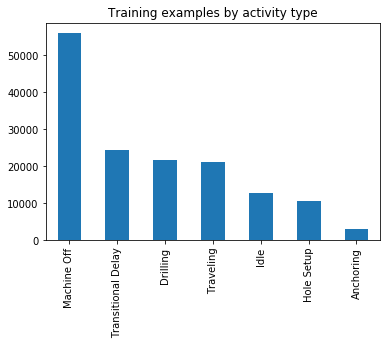

In [8]:
# A histogram to visualize the number of activities of the machine through out the entire cycle
ds_case_data['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [9]:
def plot_activity(activity, all_data):
    data = all_data[all_data['activity'] == activity][['hydraulic_pump', 'anchor', 'boom_lower']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

# plot_activity("Idle", all_data)

In [10]:
# Assign dataset to new variables
X_feats0 = ds_case_data[ds_case_data.columns.difference(['timestamp', 'Unnamed: 0'])]
X = ds_case_data[ds_case_data.columns.difference(['timestamp', 'Unnamed: 0', 'activity'])]

In [11]:
# Drop timestamp and the unamed columns
feats_with_activity = ds_case_data[ds_case_data.columns.difference(['timestamp', 'Unnamed: 0'])]
# Drop the Unnames, timestamp and activity columns
feats_without_activity = ds_case_data[ds_case_data.columns.difference(['timestamp', 'Unnamed: 0', 'activity'])]
y_target = ds_case_data['activity']

In [13]:
### ADJUST AND CLEAN DATA BY: ###
# Drop columns where number (NaNs) > 50% of the data set
# Impute the remaining columns using linear interpolation

for col in feats_without_activity.columns:

    # feats_without_activity[col] = feats_without_activity[col].replace(-200, np.nan) # check nans
    # print(col, ':', feats_without_activity[col].isna().sum()/len(feats_without_activity))
    if feats_without_activity[col][:int(len(feats_without_activity)*0.8)].isna().sum()/int(len(feats_without_activity)*0.8) > 0.5: # at least 50% in train not nan
        feats_without_activity.drop(col, axis=1, inplace=True)
    else:
        feats_without_activity[col] = feats_without_activity[col].interpolate(method='linear', limit_direction='both') # fill nans


/home/nath/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [60]:
# Formatted (normalized) Data set without activity column
feats_without_activity.head()

,anchor,beam_left,beam_right,bolt,boom_backward,boom_forward,boom_lift,boom_lower,drill_boom_in_anchor_position,drill_boom_turn_backward,drill_boom_turn_forward,drill_boom_turn_left,drill_boom_turn_right,engine_speed,hydraulic_drive_off,pvalve_drill_forward
0,0.0,0.0,0.0,0.0,0.0,0.957588,0.0,0.0,0.978591,0.0,0.0,0.0,0.0,0.337440,0.0,0.022863
1,0.0,0.0,0.0,0.0,0.0,0.957588,0.0,0.0,0.978591,0.0,0.0,0.0,0.0,0.338525,0.0,0.022863
2,0.0,0.0,0.0,0.0,0.0,0.957588,0.0,0.0,0.978591,0.0,0.0,0.0,0.0,0.336307,0.0,0.022863
3,0.0,0.0,0.0,0.0,0.0,0.957588,0.0,0.0,0.978591,0.0,0.0,0.0,0.0,0.477629,0.0,0.022863
4,0.0,0.0,0.0,0.0,0.0,0.957588,0.0,0.0,0.978591,0.0,0.0,0.0,0.0,0.431164,0.0,0.022863


In [ ]:
# Data set without activity, Unnamed and timestamp columns
feats_without_activity

Normalization of the data set

In [16]:
# Normalize data
feature_values = X_feats0.values.copy()
# normalized_df=(feature_values-feature_values.min())/(feature_values.max()-feature_values.min())

Part of the visualization of the data

In [17]:
feats_without_activity /= feats_without_activity.max()

In [18]:
### PLOTTING UTILITY FUNCTIONS ###

def plot_sensor(name):
    
    plt.figure(figsize=(16,4))

    plt.plot(train_date, train[name], label='train')
    plt.plot(test_date, test[name], label='test')
    plt.ylabel(name); plt.legend()
    plt.show()
    
def plot_autocor(name, df):
    
    plt.figure(figsize=(16,4))
    
    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()
    
    timeLags = np.arange(1,100*24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

In [76]:
### PLOT AUTOCORRELATION ###

for col in timeseries.columns:
    plot_autocor(col, train)

In [77]:
### PLOT ORIGINAL SERIES ###
import matplotlib.pyplot as plt


for col in timeseries.columns:
    plot_sensor(col)

In [19]:
feats_without_activity.head()
len(feats_without_activity)

149795

In [20]:
# Encode the activity column using the pandas module in the following manner:
0:Anchoring 	1: Drilling 	2: Hole Setup 	Idle 	3:Machine Off 	4:Transitional Delay 	5:Traveling
y_encode = pd.get_dummies(data=y_target, columns=['activity'])

In [61]:
y_encode.head()

,Anchoring,Drilling,Hole Setup,Idle,Machine Off,Transitional Delay,Traveling
0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1


In [62]:
date = ds_case_data['timestamp'].values

#### Further preprocessing

In [64]:
### SPLIT TRAIN TEST USING CLASSICAL METHOD ###
# train_date = date[:int(len(df)*0.8)]
labels={1:'Anchoring', 2:'Drilling', 3:'Hole Setup', 4:'Idle', 5:'Machine Off', 
        6:'Transitional Delay', 7:'Traveling'}
x_train_ds = feats_without_activity.values[:,0:3][:int(len(feats_without_activity)*0.8)].copy()
y_train_ds = y_encode.values[:int(len(feats_without_activity)*0.8)].copy()


test_date = feats_without_activity.values[:,0:3][int(len(feats_without_activity)*0.8):]
x_test_ds = feats_without_activity.values[:,0:3][int(len(feats_without_activity)*0.8):].copy()
y_test_ds = y_encode.values[int(len(feats_without_activity)*0.8):].copy()

print(x_train_ds.shape, x_test_ds.shape)
print(y_train_ds.shape, y_test_ds.shape)

(119836, 3) (29959, 3)
(119836, 7) (29959, 7)


In [56]:
xtrain = np.array(x_train_ds)
xtest = np.array(x_test_ds)
ytrain = np.array(y_train_ds)
ytest = np.array(y_test_ds)

In [65]:
### PLOTTING UTILITY FUNCTIONS ###

def plot_sensor(name):
    
    plt.figure(figsize=(16,4))

    plt.plot(train_date, train[name], label='train')
    plt.plot(test_date, test[name], label='test')
    plt.ylabel(name); plt.legend()
    plt.show()
    
def plot_autocor(name, df):
    
    plt.figure(figsize=(16,4))
    
    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()
    
    timeLags = np.arange(1,100*24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

In [ ]:
### PLOT ORIGINAL SERIES ###
import matplotlib.pyplot as plt


for col in timeseries.columns:
    plot_sensor(col)

In [ ]:
### PLOT AUTOCORRELATION ###

for col in timeseries.columns:
    plot_autocor(col, train)

# Generate sequences from feature inputs based on timestamps. 

Define sequences from data file as inputs

In [67]:
# Since we are working with time series data, it is vital to review some examples of the sequences.

N_TIME_STEPS = 100 ## variations were made into [64 (2 seconds), 128, 200] - Increase accuracy was observed for 64 and 100
N_FEATURES = 16
step = 20
segments = []
xs_list = []
labels = []
for i in range(0, len(feats_without_activity) - N_TIME_STEPS, step):
    xlist = [feats_without_activity[cols].values[i: i + N_TIME_STEPS] for cols in feats_without_activity.columns] ## Introduce sequences in the training data set
    label = stats.mode(feats_with_activity['activity'][i: i + N_TIME_STEPS])[0][0]  # For each tme step, assign the highest occuring activity to the corresponding label
    segments.append(xlist)
    labels.append(label)
    # labels.append(label)

In [68]:
np.array(segments).shape

(7485, 16, 100)

In [29]:
# Split the new sequences of data sets into test and training sets using Sklearn:
# 
train_size = int(len(feats_without_activity) * 0.8)
test_size = len(feats_without_activity) - train_size
train, test = feats_without_activity.values[0:train_size, :], feats_without_activity.values[train_size:, :]

We can verify the balance in terms of the individual output classes. 
We can confirm this by summarizing the class breakdown of all observations (activities).


In [30]:
# Different classes associated with the 7 classes corresponding to the Machine at different times
# With these, we can observe the frequencies of each activity of the Machine

class1, class2 = len(y_target[y_target=='Anchoring']), len(y_target[y_target=='Drilling'])
class3, class4 = len(y_target[y_target=='Hole Setup']), len(y_target[y_target=='Idle'])
class5, class6 = len(y_target[y_target=='Machine Off']), len(y_target[y_target=='Transitional Delay'])
class7 = len(y_target[y_target=='Traveling'])

print('Class=Anchoring: %d %.3f%%' % (class1, class1/len(y_target)*100))
print('Class=Drilling: %d %.3f%%' % (class2, class2/len(y_target)*100))
print('Class=Holde Setup: %d %.3f%%' % (class1, class1/len(y_target)*100))
print('Class=Idle: %d %.3f%%' % (class2, class2/len(y_target)*100))
print('Class=Machine Off: %d %.3f%%' % (class1, class1/len(y_target)*100))
print('Class=Transitional Delay: %d %.3f%%' % (class2, class2/len(y_target)*100))
print('Class=Traveling: %d %.3f%%' % (class2, class2/len(y_target)*100))

Class=Anchoring: 3077 2.054%
Class=Drilling: 21789 14.546%
Class=Holde Setup: 3077 2.054%
Class=Idle: 21789 14.546%
Class=Machine Off: 3077 2.054%
Class=Transitional Delay: 21789 14.546%
Class=Traveling: 21789 14.546%


(149795, 7)


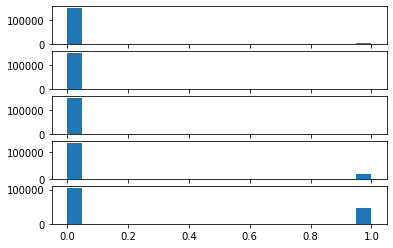

In [85]:
# histogram for 7 features
all_rows = np.vstack(feats_without_activity.values[:,0:7])
print(all_rows.shape)
plt.figure()
variables = np.array(np.arange(0, 5))  # feats_without_activity.shape[1]))
for v in variables:
	plt.subplot(len(variables), 1, v+1)
	plt.hist(all_rows[:, v], bins=20)
plt.show()

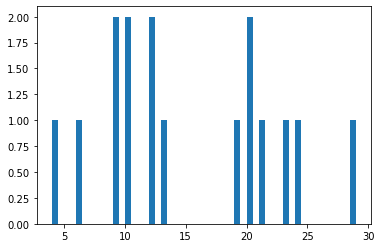

In [86]:
# histogram for trace lengths corresponding to each feature
# The idea is to group traces by their path and plot an example of one trace for each path. 

trace_lengths = [len(x) for x in feats_without_activity]
plt.hist(trace_lengths, bins=50)
plt.show()

In [46]:
# Reshape the segments to prepare the newly created sequence of training data for the model

reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)

In [48]:
# Encode the activity column alphabetically.
y_encode = pd.get_dummies(data=y_target, columns=['activity'])

In [49]:
# Get more information about the newly created training segments and labels
# Encode the newly selected activities corresponding to the newly created sequences
reshaped_segments.shape
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [53]:
# Divide the seqence of data sets into training and test sets.

RANDOM_SEED = 0
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.2, random_state=None)

In [54]:
# Dimension of training set
X_train.shape


(5988, 100, 16)

In [55]:
# Dimension of training labels (classes corresponding to the machine activities)
y_train.shape


(5988, 7)

In [56]:
# Dimension of the test set
X_test.shape

(1497, 100, 16)

In [57]:
# Dimension of the label test set

y_test.shape

(1497, 7)

In [58]:
# Define training parameters

N_CLASSES = y_encode.shape[1]
N_HIDDEN_UNITS = 64


LSTM - A type of Recurrent Neural Networks  is chosen for training the model due to its performance on time series data set. 
Initially, a 1-layered LSTM is used to train the model, a deep layer is used for training (see the 'train_model.py' file in the ../model/ folder. This resulted in a slight improvements as observed in the classification accuracy.


In [59]:
# Define the LSTM (Long short term memory) model
    
def create_LSTM_model(inputs):
    # Define weights for the LSTM Network
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    # Biases
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [60]:
# create place holders
tf.reset_default_graph()
# Define tensorflow placeholders

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])


In [61]:
# Initialize the LSTM model
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")


Loss function with regularization to avoid over-fitting during training.

In [62]:
# regularization parameter
reg_param = 0.0015
# Added l2 regularization to avoid over-fitting in model. Parameter can be adjusted as desired. Higher values can lead to fewer optimal training weights.
# Since our focus is to classify the activities in each class, guessing an initial values for the regularization parameter will provide a faster implementation path to the problem.
l2 = reg_param * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = pred_Y, labels = Y)) + l2

In [63]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))


The training part contains a lot of TensorFlow boilerplate code. Initially, training the model will be trained for 100 epochs, while keeping a track of accuracy and error:


In [64]:
N_EPOCHS = 100
BATCH_SIZE = 200

In [65]:
saver = tf.train.Saver()
# Define parameters to save the model.
# Define Epoch (total training iteration) and train the model:

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} Test Set Accuracy: {acc_test} test Set Loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

/home/nath/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 1 Test Set Accuracy: 0.8643954396247864 test Set Loss: 1.7861586809158325
epoch: 10 Test Set Accuracy: 0.945891797542572 test Set Loss: 1.0406793355941772
epoch: 20 Test Set Accuracy: 0.9465597867965698 test Set Loss: 0.7210770845413208
epoch: 30 Test Set Accuracy: 0.945891797542572 test Set Loss: 0.5329873561859131
epoch: 40 Test Set Accuracy: 0.9552438259124756 test Set Loss: 0.4196758270263672
epoch: 50 Test Set Accuracy: 0.9519038200378418 test Set Loss: 0.36690428853034973
epoch: 60 Test Set Accuracy: 0.951235830783844 test Set Loss: 0.30285942554473877
epoch: 70 Test Set Accuracy: 0.9438877701759338 test Set Loss: 0.2897137403488159
epoch: 80 Test Set Accuracy: 0.9525718092918396 test Set Loss: 0.2819763422012329
epoch: 90 Test Set Accuracy: 0.9472277760505676 test Set Loss: 0.2732309103012085
epoch: 100 Test Set Accuracy: 0.9539077877998352 test Set Loss: 0.2658754885196686

final results: accuracy: 0.9539077877998352 loss: 0.2658754885196686


# Save and Plot Results using different Metrics

In [71]:
import pickle
# save models in case they have to be used later
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', 'notebooks/checkpoint/har.pbtxt')  
saver.save(sess, save_path = "notebooks/checkpoint/har.ckpt")
sess.close()

Evaluation

# Evaluate Loss and Accuracy for Training and Test Sets.

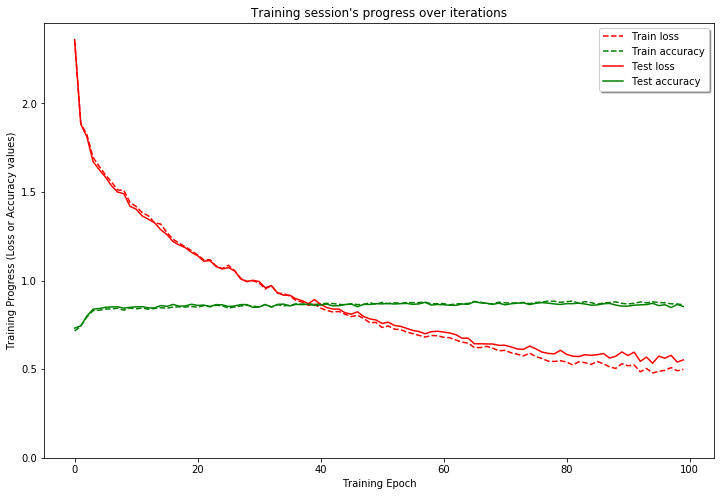

In [45]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Progress of the Training sessions over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()



The model learns well with accuracy above 95% and loss around 0.2. 
Next, we evaluate the confusion matrix for the model's predictions:

In [72]:
# We show the correctly predicted activities by plotting the confusion Matrix using the Seaborn package
LABELS = ['Machine Off', 'Idle', 'Traveling', 'Hole Setup', 'Drilling', 'Anchoring', 'T Delay']

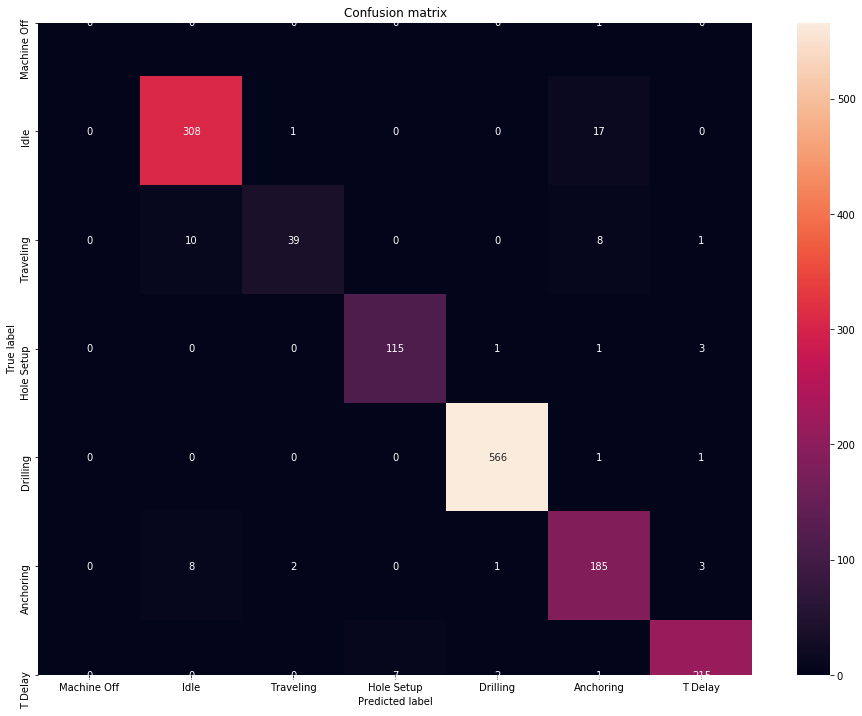

In [73]:
import seaborn as sns
from sklearn import metrics
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 12))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();